# Trabalho prático Visão por Computador

## Group 13  <br>
Nelson José Marques Martins Almeida pg52697 <br>
Carlos Gustavo Silva Pereira pg53723

## Enunciado do trabalho 1 - grupo (2-3 elementos)
Neste trabalho pretende-se explorar modelos de deep learning aplicados ao dataset GTSRB (dataset alemão de sinais de trânsito) para obter o melhor resultado possível em termos de accuracy no dataset de teste (o melhor resultado publicado é 99.82%). <br>
O trabalho divide-se em duas partes:
Numa primeira parte é suposto treinar modelos aplicando "data augmentation", tanto em pré-processamento como dinâmico. Pretende-se nesta primeira parte explorar os filtros e métodos de processamento de imagem e avaliar o impacto dos mesmos no desempenho final da rede. Parte da avaliação será ditada pelo uso das técnicas de processamento de imagem utilizadas.  Devem ser treinadas vários modelos, com "data augmentation" diferentes, e ser realizada uma análise aos resultados obtidos.
Numa segunda fase é pretendido estudar o potencial de utilizar ensembles de redes. As redes que farão parte do ensemble são as treinadas na primeira fase.
Dataset alemão:
Imagens para treino (ZIP)https://www.di.uminho.pt/~arf/storage/dl/train_images.zip
Imagens para teste (ZIP)https://www.di.uminho.pt/~arf/storage/dl/test_images.zip
Para além do notebook (ou scripts python avulsas) pretende-se um pequeno relatório que descreva as opções tomadas e apresente os testes realizados. O notebook ou as scripts também devem ser devidamente comentadas.

In [6]:
%pip install torch torchvision torchaudio torchinfo matplotlib numpy tqdm requests pandas seaborn scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pytorch-cuda==12.1 (from versions: none)
ERROR: No matching distribution found for pytorch-cuda==12.1


In [28]:

# Lets import the needed dependencies
import torch
torch.version.cuda
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

# importing a module with utilities for displaying stats and data
import sys
import os

from tqdm import tqdm
import requests
import random

# Switch to the path
sys.path.append('./util/')

#Lets import the auxiliary files
import vcpi_util
from SyntheticDataGeneration import *


DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Available device: {DEVICE}")
print(torch.cuda.is_available())


Available device: cuda:0
True


In [2]:
# Lets download the needed images if they are not already downloaded
if not os.path.exists(f'data'):
    os.makedirs(f'data')

if not os.path.exists(f"data/train"):
    print("Downloading train images...")
    if "train_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/train_images.zip")
    print("Unziping train images...")
    os.system(f"unzip data/train_images.zip -d data/")
    #os.system("rm train_images.zip")

if not os.path.exists(f"data/test"):
    print("Downloading test images...")
    if "test_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/test_images.zip")
    print("Unziping testing images...")
    os.system(f"unzip data/test_images.zip -d data/")
    #os.system("rm test_images.zip")

if not os.path.exists(f"data/German_Templates") and "German_Templates.zip" in os.listdir("data"):
  print("Extractig template images...")
  os.system(f"unzip data/German_Templates.zip -d data/")
  #os.system("rm German_Templates.zip")

if not os.path.exists(f"data/SyntheticData") and "SyntheticData.zip" in os.listdir("data"):
  print("Extractig Synthetic images...")
  os.system(f"unzip data/SyntheticData.zip -d data/")
  #os.system("rm German_Templates.zip")

print("Data downloaded and extracted successfully!")

Data downloaded and extracted successfully!


In [3]:
#Lets define the paths to store the images
PATH_TRAINING_SET = "./data/train/Final_Training/Images/"
PATH_TEST_SET = "./data/train/Final_Training/Images/"
PATH_SYNTHETIC_SET = "./data/SyntheticData/"
PATH_TEMPLATES = "./data/German_Templates/"

In [4]:
#Lets generate synthetic data to enhance the training data
# The synthetic data will be generated using templates for the signals in the dataset
syntheticDataGenerator = SyntheticDataGeneration(
    templateImagesPath=PATH_TEMPLATES,
    syntheticDataPath=PATH_SYNTHETIC_SET,
    trainingImagesPath=PATH_TRAINING_SET
    )

syntheticDataGenerator.generate()

Synthetic data for signal 0.png already generated, skipping...
Synthetic data for signal 1.png already generated, skipping...
Synthetic data for signal 10_0.png already generated, skipping...
Synthetic data for signal 10_1.png already generated, skipping...
Synthetic data for signal 11.png already generated, skipping...
Synthetic data for signal 12_0.png already generated, skipping...
Synthetic data for signal 12_1.png already generated, skipping...
Synthetic data for signal 13.png already generated, skipping...
Synthetic data for signal 14.png already generated, skipping...
Synthetic data for signal 15.png already generated, skipping...
Synthetic data for signal 16.png already generated, skipping...
Synthetic data for signal 17.png already generated, skipping...
Synthetic data for signal 18.png already generated, skipping...
Synthetic data for signal 19.png already generated, skipping...
Synthetic data for signal 2.png already generated, skipping...
Synthetic data for signal 20.png al

In [5]:
# Lets load the data
img_size = 32
#But first lets define transformations to apply to the images
transform1 = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size + 10, img_size + 10)),
    v2.RandomCrop((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
])

transform2 = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ColorJitter(brightness=random.uniform(0.2,1), contrast=random.uniform(0.2,1), saturation=random.uniform(0.2,1), hue=random.uniform(0.2,0.5)),
    v2.ToDtype(torch.float32, scale=True)
])

transform3 = v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"),
    v2.ToDtype(torch.float32, scale=True)
])


transformations = [transform1, transform2, transform3]

#For the training data we will use the training images plus the synthetic data

train_data = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=random.choice(transformations))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

synthetic_data = torchvision.datasets.ImageFolder(root=PATH_SYNTHETIC_SET, transform=random.choice(transformations))
synthetic_loader = torch.utils.data.DataLoader(synthetic_data, batch_size=32, shuffle=True)

#Lets merge the training and synthetic data
train_data = torch.utils.data.ConcatDataset([train_data, synthetic_data])
#Lets merge the labels of the training and synthetic data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
train_data = train_data.datasets[0].classes

#For the test data we will use the test images
test_data = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
    ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



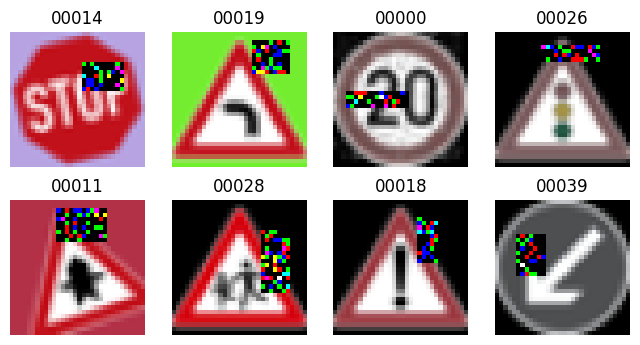

<Figure size 640x480 with 0 Axes>

In [6]:
#Lets see some of the loaded images
labels = next(iter(train_loader))

vcpi_util.show_images(2,4, labels[0], labels[1], train_data)


In [ ]:
target_list = []

for images, targets in train_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Temos o mesmo número de imagens em todos os sinais

De forma a averiguarmos se as imagens sintéticas trazem alguma vantagem vamos correr um benchmark e treinar uma rede apenas com os sinais originais com as transformações e outra com os dados aumentados com os sinais sintéticos

Para o benchmark vamos usar o mesmo dataset de validação para os dois

In [8]:
BATCH_SIZE = 32

train_noaugmentation = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=random.choice(transformations))
train_loader_noaugmentation = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

synthetic_data = torchvision.datasets.ImageFolder(root=PATH_SYNTHETIC_SET, transform=random.choice(transformations))
synthetic_loader = torch.utils.data.DataLoader(synthetic_data, batch_size=BATCH_SIZE, shuffle=True)

#Lets merge the training and synthetic data
train_augmented = torch.utils.data.ConcatDataset([train_noaugmentation, synthetic_data])
#Lets merge the labels of the training and synthetic data
train_augmented_loader = torch.utils.data.DataLoader(train_augmented, batch_size=BATCH_SIZE, shuffle=True)
train_augmented = train_augmented.datasets[0].classes

# Vamos dar split em 80 20 dos dados de treino originais para termos um dataset de validação
train_noaugmentation_sub, val_sub = torch.utils.data.random_split(train_noaugmentation, [int(0.8*len(train_noaugmentation)), int(0.2*len(train_noaugmentation))])
train_noaugmentation_sub_loader = torch.utils.data.DataLoader(train_noaugmentation_sub, batch_size = 32, shuffle = True)
val_sub_loader = torch.utils.data.DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=True)

#For the test data we will use the test images
test_data = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=v2.Compose([
    v2.ToImage(),
    v2.Resize((img_size, img_size)),
    v2.ToDtype(torch.float32, scale=True)
    ]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Vamos ver os dados em cada dataset

Counter({2: 1830, 1: 1772, 4: 1576, 5: 1505, 12: 1473, 3: 1118, 7: 1112, 10: 1003, 18: 987, 8: 884, 25: 820, 9: 644, 13: 530, 23: 425, 6: 331, 22: 323, 20: 287, 21: 274, 11: 268, 24: 215, 42: 186, 41: 184, 40: 184, 14: 174, 19: 171, 0: 170, 17: 110, 16: 58, 15: 54, 26: 45, 38: 30, 39: 26, 31: 24, 28: 23, 30: 22, 35: 21, 33: 16, 29: 14, 27: 9, 34: 6, 37: 5, 36: 4, 32: 3})


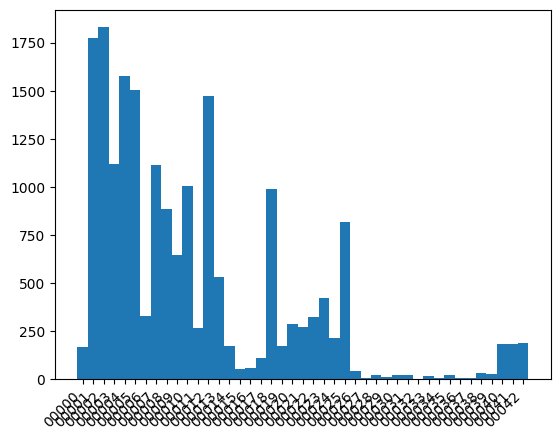

In [9]:
# Imagens no dataset sem data augmentation
target_list = []

for _, targets in train_noaugmentation_sub_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Counter({32: 2451, 16: 2451, 30: 2451, 31: 2451, 26: 2451, 34: 2451, 37: 2451, 39: 2451, 36: 2451, 33: 2451, 27: 2451, 29: 2451, 8: 2450, 15: 2450, 21: 2450, 38: 2450, 6: 2450, 7: 2450, 11: 2450, 24: 2450, 1: 2450, 9: 2450, 5: 2450, 40: 2450, 17: 2450, 0: 2450, 13: 2450, 20: 2450, 18: 2450, 19: 2450, 12: 2450, 23: 2450, 2: 2450, 25: 2450, 3: 2450, 41: 2450, 22: 2450, 42: 2450, 10: 2450, 35: 2450, 14: 2450, 4: 2450, 28: 2248})


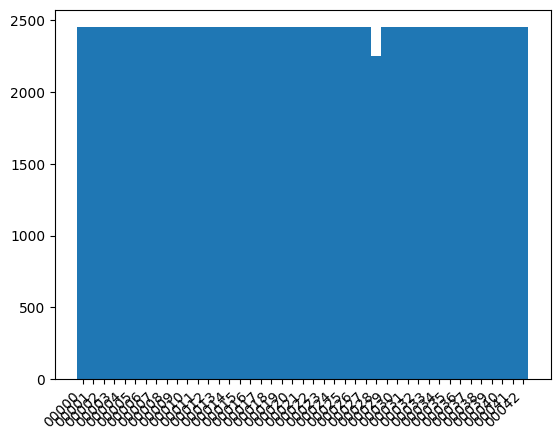

In [11]:
#Imagens no dataset com data augmentation
target_list = []

for _, targets in train_augmented_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Counter({1: 448, 2: 420, 4: 404, 12: 381, 5: 355, 3: 292, 7: 286, 10: 265, 25: 231, 8: 228, 18: 213, 9: 177, 13: 153, 6: 89, 23: 85, 20: 73, 11: 69, 22: 67, 21: 56, 24: 55, 42: 48, 14: 46, 41: 45, 40: 42, 0: 40, 19: 39, 17: 24, 16: 19, 26: 18, 15: 12, 35: 8, 31: 7, 33: 6, 30: 6, 38: 5, 37: 4, 28: 4, 27: 3, 29: 3, 39: 1, 34: 1, 36: 1})


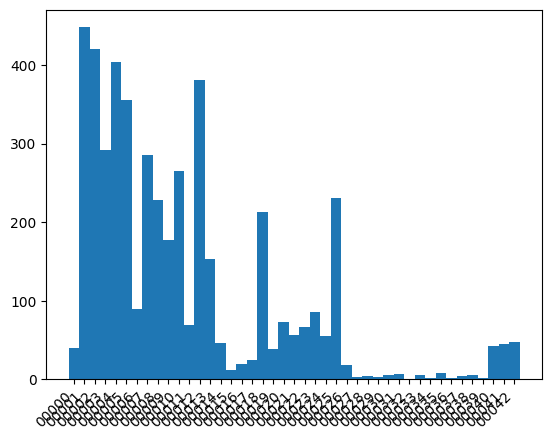

In [10]:
#Imagens no dataset de validação
target_list = []

for _, targets in val_sub_loader:

    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data)

Vamos então definir uma rede neuronal convulocional para o nosso modelo.

In [12]:
class Conv_I(torch.nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)

    def forward(self, x):

        #input = (bs, 1, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.maxpool1(x) # -> (bs, 32, 14, 14)

        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)

        x = torch.flatten(x,1) # (bs, 48, 5 ,5 -> (bs,1200))
        x = self.fc1(x) # (bs, 1200) -> (bs, 10)

        return(x)

Vamos definir funções auxiliares como early stopping e schedulers

In [13]:
# Quando de uma época para outra perdermos a acc_val, é sinal que o modelo está a dar overfit e para isso podemos diminuir o learning rate
# Early stopping é quando paramos o treino quando a loss da validação não melhora ao fim de x épocas
#TODO isto devia ir para o util
class Early_Stopping():

    def __init__(self, patience=3, min_delta=0.000001):
        self.patience = patience
        self.min_delta = min_delta

        self.min_loss = np.inf
        self.counter = 0

    def __call__(self, loss):
        if (loss+self.min_delta < self.min_loss):
            self.min_loss = loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter > self.patience:
                return True

        return False

#TODO: Permitir que seja passado um optimizer pelo utilizador
class Scheduler():
  def __init__(self, model, T_max = 10, eta_min=0.000001, num_epochs = 10):
    self.scheduling_optimizer = torch.optim.Adam(model.parameters())

    self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.scheduling_optimizer, T_max=T_max, eta_min=eta_min)

    lrs = []

    for _ in range(num_epochs):
        self.scheduler.step()
        lrs.append(self.scheduling_optimizer.param_groups[0]['lr'])


def build_confusion_matrix(model, dataset, test_set):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(DEVICE))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))      


In [43]:
# De forma a estabilizar os resultados, quando a accuracy não melhora ao fim de x épocas, atualizamos a taxa de aprendizagem para uma mais baixa
# Ao pararmos quando piora/não melhora convém guardarmos a iteração anterior visto esta ser a melhor
def train(model, training_data,  data_loader, val_sub_loader, epochs, loss_fn, optimizer, scheduler, early_stopping, save_prefix="model", path_name = ""):

    if "models" not in os.listdir():
      os.mkdir("models")

    #Lets create the path to save the model  
    if path_name not in os.listdir("models"):
      date = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
      if path_name == "": path_name = f"model_{date}"
      os.mkdir(f"models/{path_name}")

    #Lets create the logs file
    logfile = open(f"models/{path_name}/logs_{path_name}.txt", "a")

    model.train()

    history = {}
    history['accuracy'] = []
    history['val_accuracy'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf


    for epoch in range(epochs):
        # O droput durante o treino deita fora alguns neurónios, durante a avaliação usa sempre os neurónios todos
        # Batch normalization durante o treino usa a média e o desvio padrão da batch que recebeu, mas durante a avaliação usa a média que vai calculando durante o treino
        #  Todos os outros layers são iguais durante o treino e avaliação
        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            _,pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()
            running_loss += loss

        
        model.eval()
        t_correct = 0
        val_loss = 0
        # torch.no_grad() é usado para desativar o cálculo do gradiente, o que acelera o processo e reduz a memória
        with torch.no_grad():
            for i,t in val_sub_loader:
                i = i.to(DEVICE)
                t = t.to(DEVICE)
                o = model(i)
                _,p = torch.max(o, 1)
                t_correct += (t == p).sum()

                # Loss entre os targets e os outputs
                val_loss += loss_fn(o,t)

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if old_lr != new_lr:
            print(f'==> Learning rate changed from {old_lr} to {new_lr}')
            #Lets write the changes to the log file
            logtime = datetime.datetime.now().strftime("%H_%M_%S")
            logfile.write(f"[{logtime}] -> Learning rate changed from {old_lr} to {new_lr} in {epoch} epoch\n")
        

        stop_time = time.time()
        accuracy = 100 * correct/len(training_data)
        val_accuracy = 100*t_correct/len(val_sub)
        
        print(f'Epoch: {epoch:03d}; Acc = {accuracy:0.4f}; Val_loss = {val_loss}; Vall_acc: {val_accuracy}; Time: {(stop_time- start_time):0.4f}')
        history["val_accuracy"].append(val_accuracy.cpu().numpy())
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "accuracy": accuracy,
                "val_accuracy": val_accuracy,
                "loss": running_loss,
                "val_loss": val_loss,
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict()
                },
                f"models/{path_name}/{save_prefix}_{epoch}.pth"
            )
            print("==> Model saved")
            #Lets write to the log file
            logtime = datetime.datetime.now().strftime("%H_%M_%S")
            logfile.write(f"[{logtime}] -> Model saved with name {save_prefix}_{epoch} in {epoch} epoch with validation loss={val_loss}\n")
        
        if early_stopping(val_loss):
            print("==> Early stopping")
            #Lets write to the log file
            logtime = datetime.datetime.now().strftime("%H_%M_%S")
            logfile.write(f"[{logtime}] -> Training stopped early with {val_loss} validation loss in epoch {epoch}\n")
            break

    #Lets write to the log file
    logtime = datetime.datetime.now().strftime("%H_%M_%S")
    logfile.write(f"[{logtime}] -> Training finished with {val_loss} loss {accuracy} accuracy with training data and {val_accuracy} accuracy in the validation data in epoch {epoch}\n")
    endtime = time.time()
    time_elapsed = endtime - start_time
    print(f"==> Training finished in {time_elapsed} minutes")
    return(history)

In [47]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(DEVICE))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


In [48]:
EPOCHS = 30

model_I_noaugmentation = Conv_I(len(train_data)).to(DEVICE)
optimizer_I = torch.optim.Adam(model_I_noaugmentation.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

In [51]:
save_prefix="model_I_noaugmentation"
path_name="model_I_noaugmentation"
history_I_noagumentation = train(model_I_noaugmentation, train_noaugmentation, train_noaugmentation_sub_loader, val_sub_loader, EPOCHS, loss_fn, optimizer_I, scheduler, early_stopping, save_prefix, path_name)
torch.save(model_I_noaugmentation.state_dict(), f"models/{path_name}/{save_prefix}_best.pth")

Epoch: 000; Acc = 73.0049; Val_loss = 37.036109924316406; Vall_acc: 92.4296875; Time: 24.2220
==> Model saved
Epoch: 001; Acc = 76.1979; Val_loss = 20.63798713684082; Vall_acc: 95.79192352294922; Time: 23.7770
==> Model saved
Epoch: 002; Acc = 77.4202; Val_loss = 13.283478736877441; Vall_acc: 97.69507598876953; Time: 24.0380
==> Model saved
Epoch: 003; Acc = 77.5809; Val_loss = 11.551730155944824; Vall_acc: 97.73736572265625; Time: 23.2200
==> Model saved
Epoch: 004; Acc = 78.4394; Val_loss = 12.551431655883789; Vall_acc: 97.48361206054688; Time: 20.2470
Epoch: 005; Acc = 78.3548; Val_loss = 7.496036052703857; Vall_acc: 98.5409164428711; Time: 20.1030
==> Model saved
Epoch: 006; Acc = 78.6889; Val_loss = 6.679048538208008; Vall_acc: 98.62550354003906; Time: 20.2610
==> Model saved
Epoch: 007; Acc = 78.9385; Val_loss = 4.946371078491211; Vall_acc: 99.0907211303711; Time: 20.2930
==> Model saved
Epoch: 008; Acc = 78.9638; Val_loss = 6.00596809387207; Vall_acc: 98.94269561767578; Time: 20

In [52]:
#Vamos avaliar o modelo 
best_train = np.asarray(history_I_noagumentation['accuracy']).argmax()
best_val = np.asarray(history_I_noagumentation['val_accuracy']).argmax()


In [53]:
evaluate(model_I_noaugmentation, test_loader)

0.9825332760810852

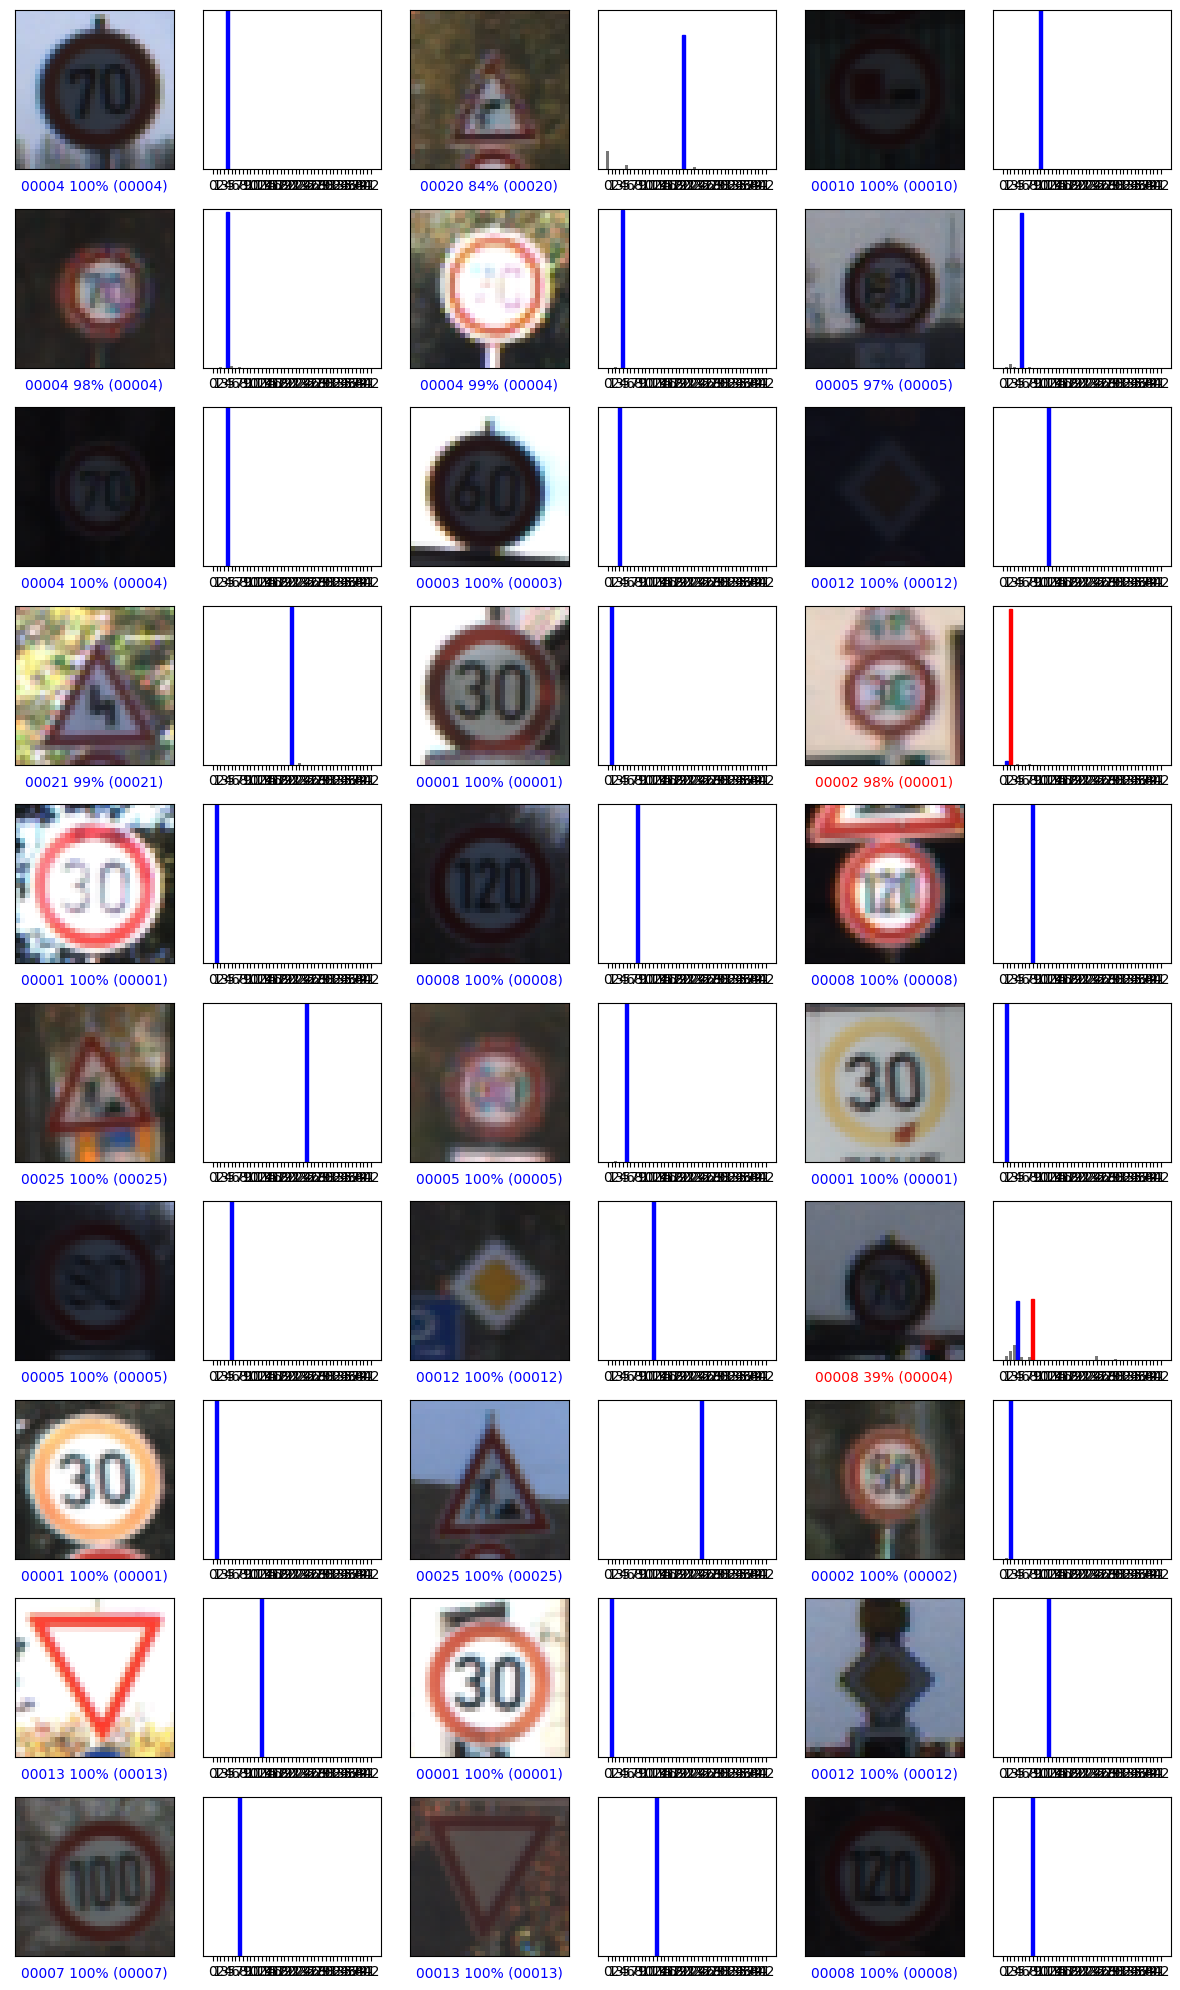

In [58]:

images, targets = next(iter(test_loader))
logits = model_I_noaugmentation(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_noaugmentation.classes, 10, 3)

In [54]:
# Vamos agora testar o modelo com data augmentation
model_I_augmentation = Conv_I(len(train_augmented)).to(DEVICE)
optimizer_I = torch.optim.Adam(model_I_augmentation.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

In [55]:
history_I_augmented = train(model_I_augmentation, train_augmented, train_augmented_loader, val_sub_loader, EPOCHS, loss_fn, optimizer_I, scheduler, early_stopping, "model_I_augmented", "model_I_augmented")
torch.save(model_I_augmentation.state_dict(), f"models/model_I_augmented/model_I_augmented_best.pth")

c:\Users\ruben\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 000; Acc = 223341.8594; Val_loss = 71.1170425415039; Vall_acc: 85.00740051269531; Time: 99.9777
==> Model saved
Epoch: 001; Acc = 238565.1094; Val_loss = 26.371431350708008; Vall_acc: 95.00951385498047; Time: 96.4142
==> Model saved
Epoch: 002; Acc = 240813.9531; Val_loss = 26.139575958251953; Vall_acc: 94.65003204345703; Time: 96.3961
==> Model saved
Epoch: 003; Acc = 241906.9688; Val_loss = 9.442506790161133; Vall_acc: 98.39289855957031; Time: 97.1424
==> Model saved
Epoch: 004; Acc = 242495.3438; Val_loss = 12.927982330322266; Vall_acc: 97.63163757324219; Time: 96.6159
Epoch: 005; Acc = 243027.9062; Val_loss = 8.704771041870117; Vall_acc: 98.05455780029297; Time: 96.7219
==> Model saved
Epoch: 006; Acc = 243106.9688; Val_loss = 5.822949409484863; Vall_acc: 98.87925720214844; Time: 95.8981
==> Model saved
Epoch: 007; Acc = 243234.8906; Val_loss = 5.242554187774658; Vall_acc: 98.85810852050781; Time: 96.0060
==> Model saved
Epoch: 008; Acc = 243590.7031; Val_loss = 7.5048851966

In [56]:
#Vamos avaliar o modelo 
best_train_augmented = np.asarray(history_I_augmented['accuracy']).argmax()
best_val_augmented = np.asarray(history_I_augmented['val_accuracy']).argmax()

In [57]:
evaluate(model_I_augmentation, test_loader)

0.9702262878417969

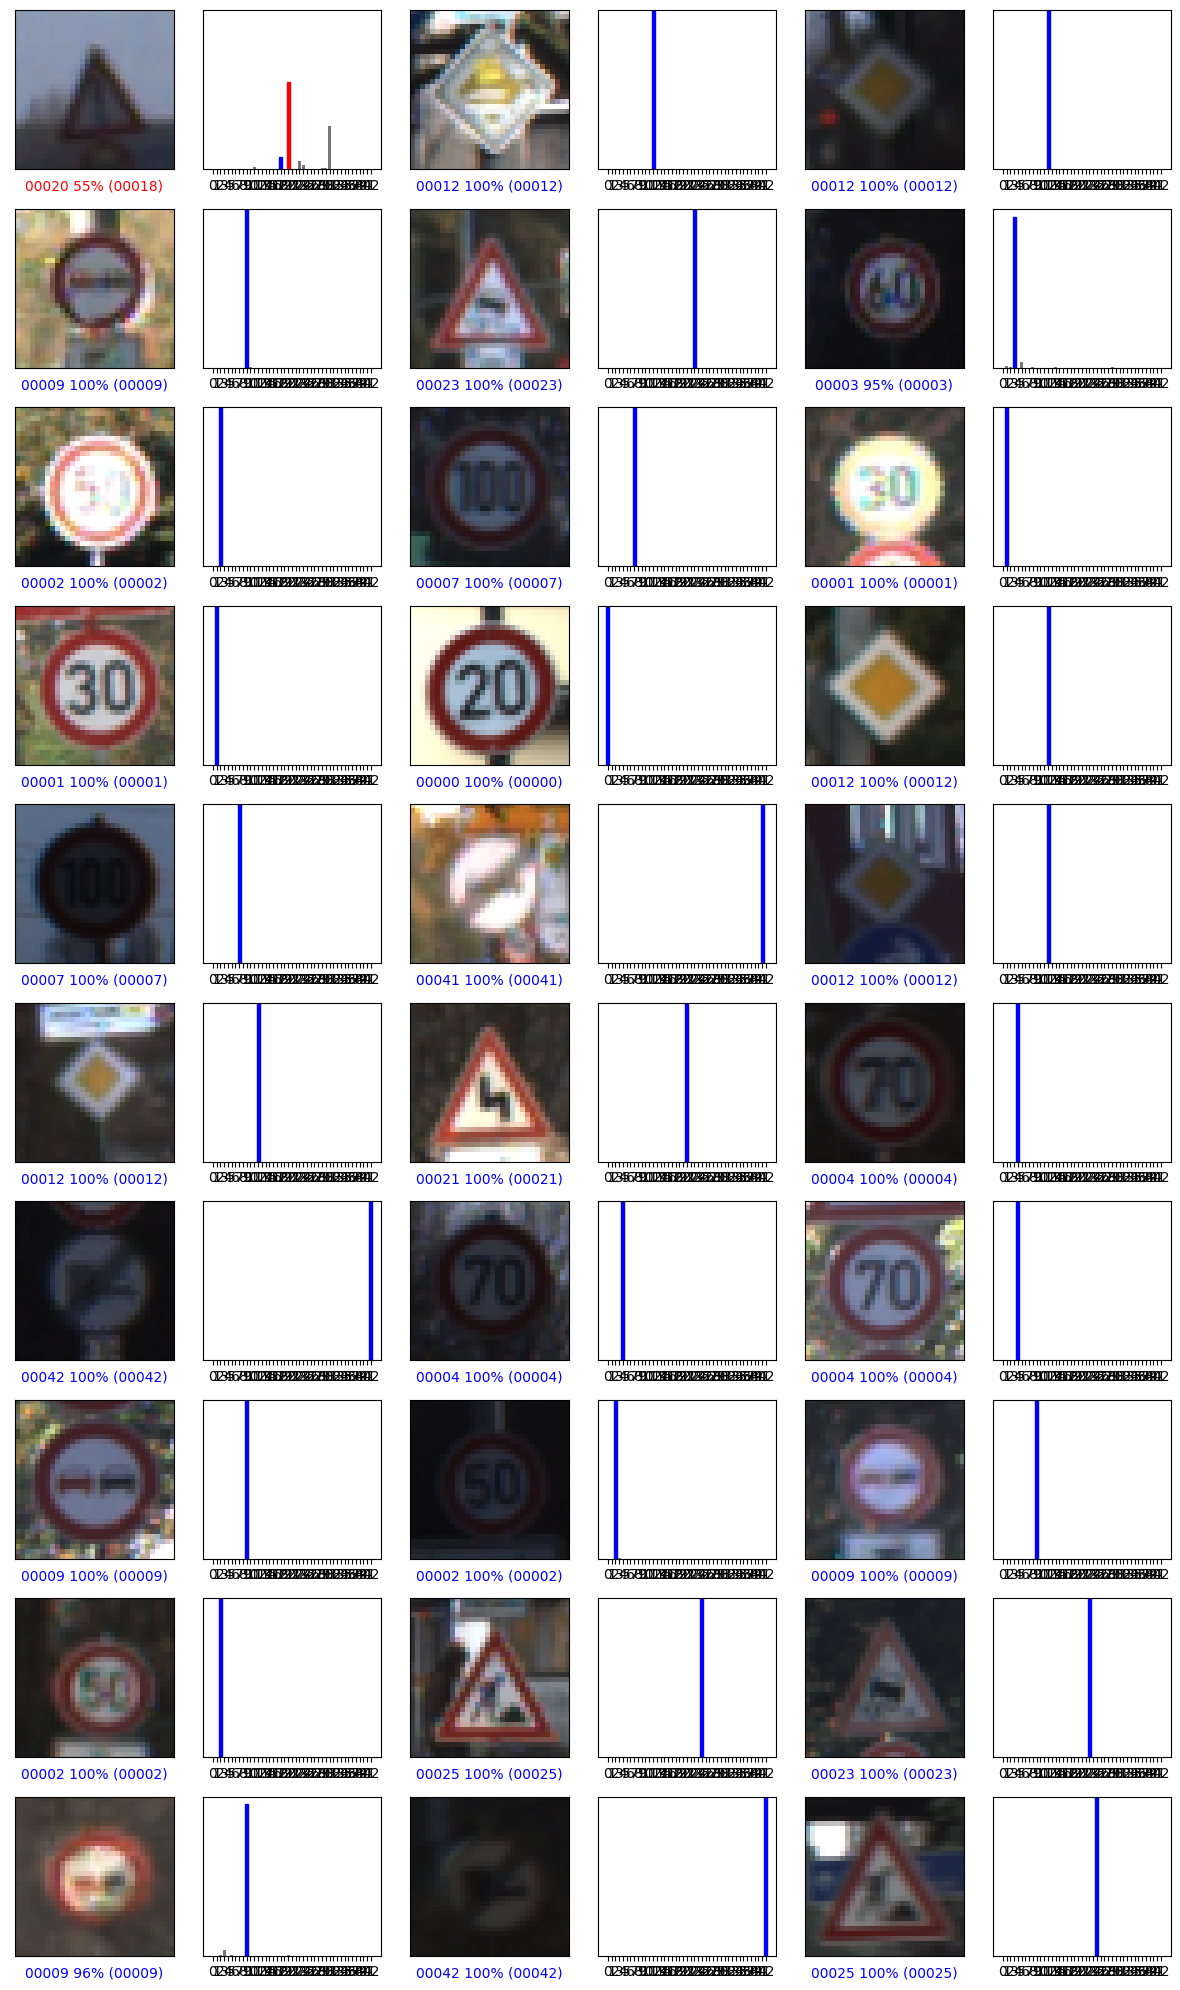

In [61]:
images, targets = next(iter(test_loader))
logits = model_I_augmentation(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_augmented, 10, 3)